# Emotions Data Exploration and Analysis
## Introduction
This project aims to explore and analyse the "Emotions" dataset, which consists of English Twitter messages annotated with six fundamental emotions. The goal is to understand and analyse the diverse spectrum of emotions expressed in short-form text on social media.


## 1. Import Libraries
To begin, we import the necessary Python libraries that will be used throughout this notebook. These libraries include Pandas for data manipulation, NumPy for numerical operations, Matplotlib and Seaborn for visualization, and IPython's display for enhanced output display.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
import nltk
from wordcloud import WordCloud
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Additional setup for this notebook (if any)


[nltk_data] Downloading package stopwords to C:\Users\Sechaba
[nltk_data]     Mohlabeng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Sechaba
[nltk_data]     Mohlabeng\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 2. Load Dataset
Next, we load the dataset from a CSV file into a Pandas DataFrame. This allows us to manipulate and analyze the data effectively.

In [6]:
df = pd.read_csv('data/emotions.csv')

## 3. Explore Dataset

### 3.1 View First Few Rows

To get a sense of the dataset's structure and content, we display the first few rows.

In [17]:
display(df.head(10))

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
5,5,i was beginning to feel quite disheartened,0
6,6,i would think that whomever would be lucky eno...,2
7,7,i fear that they won t ever feel that deliciou...,1
8,8,im forever taking some time out to have a lie ...,5
9,9,i can still lose the weight without feeling de...,0


### 3.2 Data Information
Understanding the dataset's structure, including the number of entries, columns, and types of data, is crucial. Therefore, we display this information as follows:

In [32]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    416809 non-null  int64 
 1   text          416809 non-null  object
 2   label         416809 non-null  int64 
 3   tweet_length  416809 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 12.7+ MB


None

### 3.3 Checking for Missing Values
It's important to check for missing or null values in our dataset, as they can significantly impact the analysis and model training process. Identifying and addressing these missing values early on ensures that our data cleaning and preprocessing steps are effective and that our analysis is accurate.

In [29]:
# Create a DataFrame to display missing values count and percentage
missing_values_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': df.isnull().sum(),
    'Percentage of Total': (df.isnull().sum() / len(df)) * 100
}).reset_index(drop=True)

# Display the DataFrame with missing values information
missing_values_df

,Column,Missing Values,Percentage of Total
0,Unnamed: 0,0,0.0
1,text,0,0.0
2,label,0,0.0
3,tweet_length,0,0.0


### 3.4 Preliminary Data Exploration

Before cleaning the data, let's conduct some preliminary exploration to uncover more insights from the dataset. This exploration can help in understanding the distribution of emotions across the tweets, identifying potential outliers, and discovering patterns that might inform our cleaning and analysis strategy.

#### Distribution of Emotions
A good starting point is to look at how tweets are distributed across the different emotion categories. This can help identify if the dataset is balanced or if there are categories with significantly more or fewer tweets.

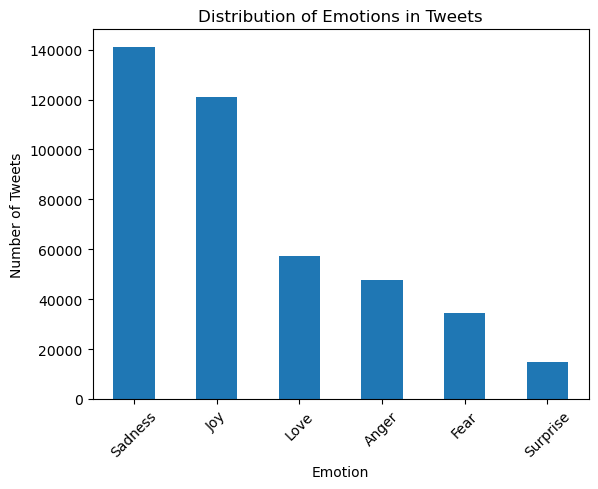

In [21]:
# Plotting the distribution of emotions
emotion_counts = df['label'].value_counts()
emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotions in Tweets')
plt.xlabel('Emotion')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=range(6), labels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'], rotation=45)
plt.show()

#### Examining Tweet Lengths
Analysing the length of the tweets can provide insights into how the amount of text correlates with the expressed emotions. It might reveal if certain emotions tend to be expressed more succinctly or verbosely.

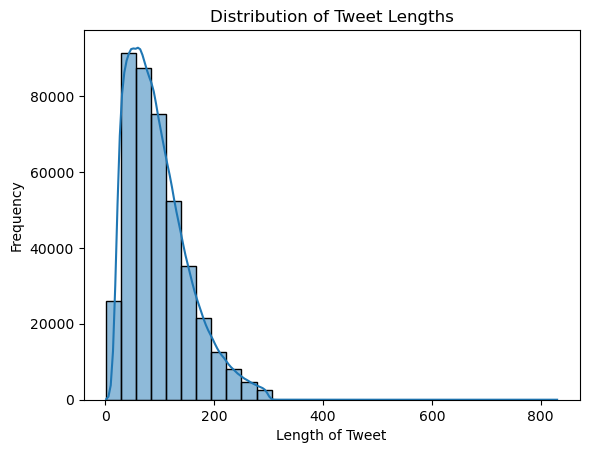

In [22]:
# Adding a new column for tweet length
df['tweet_length'] = df['text'].apply(len)

# Plotting the distribution of tweet lengths
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

## 4: Data Cleaning and Text Preprocessing
In this section, we performed several steps to prepare our dataset for exploratory data analysis and modeling. These steps include:

1. **Removing Duplicates**: To ensure the uniqueness of each tweet, we removed duplicate entries based on the `text` and `label` columns. This step is crucial to prevent any bias that duplicates might introduce to our analysis or model.

2. **Text Preprocessing**: We applied a comprehensive text preprocessing function to each tweet. This function:
   - Converts text to lowercase to standardize the case.
   - Removes URLs, mentions, and hashtags as these elements do not contribute to our analysis of emotions.
   - Eliminates words with two or fewer characters, punctuation, and numbers, focusing on more meaningful content.
   - Removes stop words using NLTK's list of English stop words. Stop words are common words that usually do not carry significant meaning and are thus removed.
   - Strips extra spaces, leaving only one space between words and no leading or trailing spaces.

By the end of this section, we have a cleaned dataset, `df_cleaned`, ready for further analysis. The dataset is now more standardised and focused on content that is potentially more relevant for understanding emotions expressed in tweets.

---

### 4.1 Remove Duplicate Entries
First, lets ensure the dataset contains only unique entries to maintain the integrity of our analysis.

In [34]:
# Remove duplicate rows
df_cleaned = df.drop_duplicates(subset=['text', 'label'])
print(f"Shape after removing duplicates: {df_cleaned.shape}")

Shape after removing duplicates: (416123, 4)


### 4.2 Text Preprocessing
Now, let's clean the text data with the following function. This function will be applied to each tweet to standardize the format and remove unnecessary elements.

In [39]:
# Remove duplicate rows and explicitly create a new DataFrame
df_cleaned = df.drop_duplicates(subset=['text', 'label']).copy()

# Set of English stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Define a function to clean text data
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove words with 2 or less characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stop words
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply the text cleaning function to the 'text' column
df_cleaned['text'] = df_cleaned['text'].apply(clean_text)

# Display the first few rows of the cleaned dataframe
df_cleaned.head()


,Unnamed: 0,text,label,tweet_length
0,0,feel really helpless heavy hearted,4,45
1,1,ive enjoyed able slouch relax unwind frankly n...,0,234
2,2,gave internship dmrg feeling distraught,4,63
3,3,dont know feel lost,0,26
4,4,kindergarten teacher thoroughly weary job take...,4,222


## 5. Exploratory Data Analysis (EDA)

With our dataset cleaned and preprocessed, we're now ready to move into exploratory data analysis (EDA). EDA will allow us to dive deeper into our dataset, uncovering patterns, trends, and insights about the emotions expressed in tweets. 

In this section, we will:
- Analyse the distribution of emotions across our dataset to see how different emotions are represented.
- Explore the length of tweets to understand if the amount of text used varies by emotion.
- Conduct word frequency analysis to identify common words across all tweets and within each emotion category, providing insights into the language of emotional expression on Twitter.

The goal of EDA is to gain a better understanding of our data's characteristics and to inform our approach to feature engineering and model building in later sections.


### 5.1 Distribution of Emotions
Understanding how emotions are distributed can inform us about the balance of our dataset and potential biases towards certain emotions.



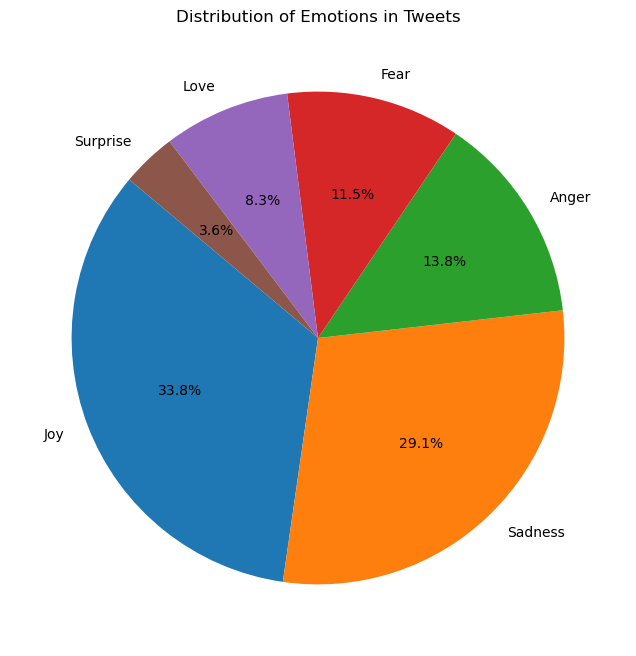

In [51]:
# Calculate the distribution of emotions as percentages
emotion_percentages = df_cleaned['label'].value_counts(normalize=True) * 100

# Optional: Mapping for emotion labels to descriptive names
emotion_mapping = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
emotion_labels = emotion_percentages.index.map(emotion_mapping).tolist()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_percentages, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotions in Tweets')
plt.show()


Earlier, in our preliminary data exploration (Section 3.4), we visualised the distribution of emotions based on the number of tweets for each emotion. This provided us with a clear understanding of the absolute sizes of each category within our dataset.

Building on this, we now present the distribution of emotions as percentages of the total dataset. This perspective offers insight into the relative distribution of each emotion, highlighting the balance or imbalance among categories in a more nuanced way.

Including both absolute and relative distributions allows us to appreciate not only the scale of data available for each emotion but also how each emotion's representation compares to the others within the context of our entire dataset. This dual view enriches our understanding and sets a solid foundation for the detailed exploratory data analysis to follow.


### 5.2 Tweet Length Analysis
Exploring the length of tweets across different emotions can reveal if certain emotions tend to be expressed with more or fewer words.

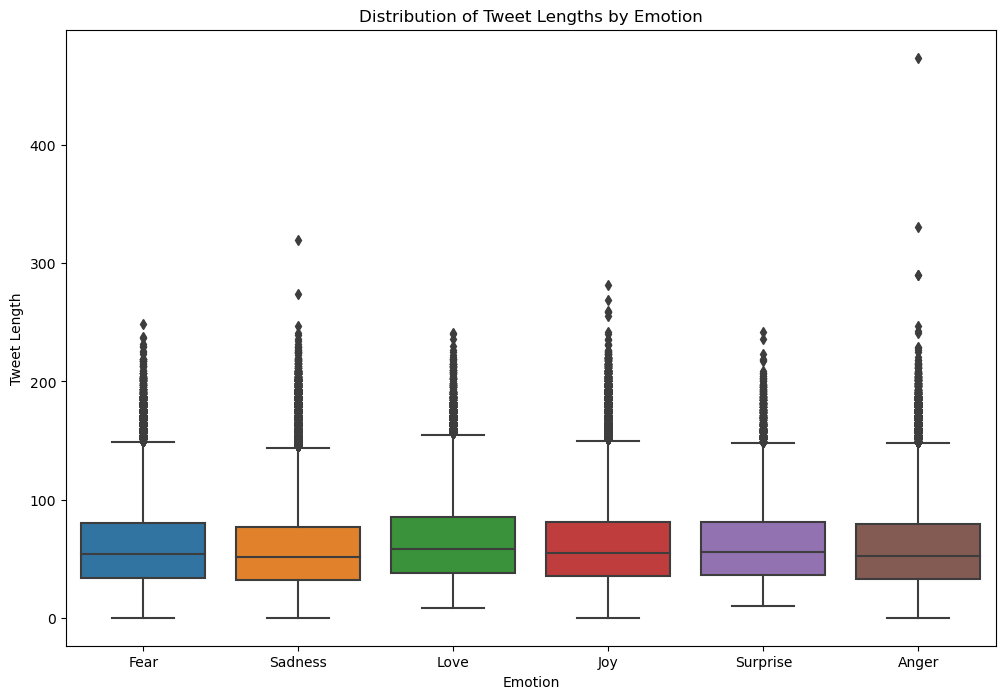

In [43]:
# Add a new column for tweet length
df_cleaned['tweet_length'] = df_cleaned['text'].apply(len)

# Visualize the distribution of tweet lengths for each emotion
plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='tweet_length', data=df_cleaned.replace({'label': emotion_mapping}))
plt.title('Distribution of Tweet Lengths by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Tweet Length')
plt.show()


### 5.3 Word Frequency Analysis
Identifying the most common words used in the tweets, overall and within each emotion category, can provide insights into the language of emotional expression.

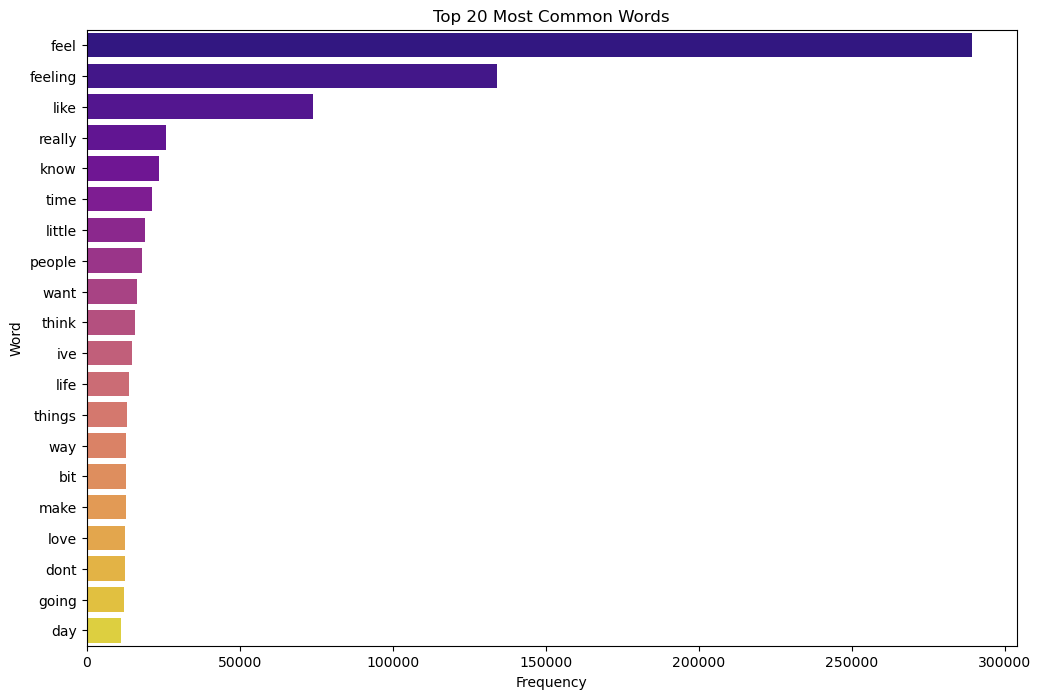

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the cleaned tweets
word_counts = vectorizer.fit_transform(df_cleaned['text'])

# Sum word occurrences
sum_words = word_counts.sum(axis=0)

# Map word indices to actual words
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Display the top 20 words
top_words = words_freq[:20]
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=top_words_df, palette='plasma')
plt.title('Top 20 Most Common Words')
plt.show()


### 5.4 Sentiment Intensity Analysis with VADER
First, you'll need to install and import VADER (Valence Aware Dictionary and sEntiment Reasoner), which is part of the NLTK library.

In [47]:
# Import VADER's SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to get compound sentiment score
def get_sentiment_score(tweet):
    return sia.polarity_scores(tweet)["compound"]

# Apply the function to get sentiment score for each tweet
df_cleaned['sentiment_score'] = df_cleaned['text'].apply(get_sentiment_score)

# View the first few rows to confirm the sentiment scores are added
df_cleaned.head()

,Unnamed: 0,text,label,tweet_length,sentiment_score
0,0,feel really helpless heavy hearted,4,34,-0.5095
1,1,ive enjoyed able slouch relax unwind frankly n...,0,147,0.6221
2,2,gave internship dmrg feeling distraught,4,39,-0.4767
3,3,dont know feel lost,0,19,0.2411
4,4,kindergarten teacher thoroughly weary job take...,4,131,-0.7178


### Sentiment Scores Explanation

In our sentiment analysis using VADER (Valence Aware Dictionary and sEntiment Reasoner), each tweet is assigned a sentiment score that ranges from -1 to 1:

- **Negative Sentiment**: Scores less than 0 indicate a negative sentiment.
- **Neutral Sentiment**: A score of 0 indicates a neutral sentiment.
- **Positive Sentiment**: Scores greater than 0 indicate a positive sentiment.

These scores help us understand the overall sentiment expressed in each tweet. By comparing these scores across different emotions, we can gain insights into the general sentiment (positive, neutral, or negative) associated with each emotional category.


## 6. Database Integration and SQL Analysis

Having completed our data cleaning and exploratory data analysis, we now transition into integrating our dataset with a database and conducting analysis through SQL queries. This section outlines the process of exporting our cleaned data to a CSV file, setting up a SQLite database, importing our data into this database, and utilising SQL queries for further data exploration. This step marks our venture into data engineering, showcasing our ability to work across different data platforms and demonstrating essential SQL skills.

### 6.1 Exporting Cleaned Data to CSV


In [55]:
# Export the cleaned DataFrame to a CSV file with an updated name
df_cleaned.to_csv('C:\\Users\\Sechaba Mohlabeng\\Downloads\\emotions dataset\\cleaned_emotions.csv', index=False)

### 6.2 Setting Up a SQLite Database Using DB Browser

To facilitate the integration of our cleaned dataset into a SQL environment for further analysis, we've chosen to use DB Browser for SQLite, a graphical database management tool. This decision leverages the convenience and user-friendly interface of DB Browser, allowing us to visually manage the database without writing SQL commands for setup tasks.

#### Steps Taken:

1. **DB Browser Installation**: Already installed on my local machine, DB Browser for SQLite provides a robust platform for database creation, schema design, and data manipulation.

2. **Creating a New Database**:
    - Launched DB Browser and selected "New Database".
    - Named the database `emotionstweets.db` and saved it in a project-specific directory. This creates a new, empty database ready for data import.

3. **Preparation for Data Import**: At this stage, no tables were manually created in the database. The table structure will be automatically defined during the import of our `cleaned_emotions.csv` file to ensure alignment with our dataset's schema.

#### Rationale:

This approach not only simplifies the database setup process but also provides an intuitive platform for conducting SQL queries and visualizing the database structure. By using DB Browser for SQLite, we can efficiently manage our database and prepare it for the subsequent import of cleaned data, setting the stage for detailed SQL-based data analysis.

---

In the following section, we will proceed with importing our cleaned dataset into the newly created `emotionstweets.db`, utilizing DB Browser's import functionality to seamlessly transition our data into the SQL environment.


### 6.3 Connecting to the Database

Before we can run any SQL queries to analyze our data, we need to establish a connection to our `emotionstweets.db` database. This can be achieved using DB Browser for SQLite for a graphical interface or programmatically through Python for those who prefer a coding approach.

#### Required Imports and Extension Loading

In [1]:
# Required imports
import sqlalchemy

# Load the SQL extension for Jupyter notebooks
%load_ext sql


#### Establishing Database Connection

Using the `%sql` magic command, we connect to our SQLite database.

In [2]:
%sql sqlite:///emotionstweets.db

### 6.4 Preparing the Database for Analysis
Before diving into specific SQL queries to analyze our dataset, we'll make two key adjustments to our database:

**a. Update Emotion Labels**: Convert numerical emotion labels to their word-based descriptions directly within the database. This change will enhance the readability of our analysis and make our results more accessible.

In [4]:
%%sql
UPDATE cleaned_emotions
SET label = 
    CASE
        WHEN label = 0 THEN 'Sadness'
        WHEN label = 1 THEN 'Joy'
        WHEN label = 2 THEN 'Love'
        WHEN label = 3 THEN 'Anger'
        WHEN label = 4 THEN 'Fear'
        WHEN label = 5 THEN 'Surprise'
    END;

 * sqlite:///emotionstweets.db
416123 rows affected.


[]

**b. Rename Table**: Change our table name from cleaned_emotions to tweets for simplicity and clarity moving forward.

In [6]:
%%sql
ALTER TABLE cleaned_emotions RENAME TO tweets;

 * sqlite:///emotionstweets.db
Done.


[]

### 6.5 Running Analysis Queries
With these adjustments, our database is now better prepared for our analysis. The table tweets contains descriptive labels for emotions, making our subsequent queries more intuitive.

Example Queries
Now, let's proceed with our analysis by running some example queries on the tweets table:

1. Quantify the Distribution of Emotions:

In [7]:
%%sql
SELECT label, COUNT(*) as total_tweets
FROM tweets
GROUP BY label
ORDER BY total_tweets DESC;

 * sqlite:///emotionstweets.db
Done.


label,total_tweets
Joy,140779
Sadness,120989
Anger,57235
Fear,47664
Love,34497
Surprise,14959


2. Average Tweet Length by Emotion:

In [9]:
%%sql
SELECT label, ROUND(AVG(LENGTH(text))) as average_length
FROM tweets
GROUP BY label
ORDER BY average_length DESC;

 * sqlite:///emotionstweets.db
Done.


label,average_length
Love,65.0
Surprise,63.0
Joy,62.0
Fear,61.0
Anger,60.0
Sadness,59.0
